# Libraries

In [1]:
require(plyr)
require(tableone)
require(gamm4)
require(MuMIn)
require(ggplot2)
require(tidyr)
require(stringr)
require(gridExtra)
require(lmtest)
library(reshape)
library(latex2exp)
require(boot)
library(feather)
library(parallel)
library(purrr)
source('univariate_models.r')

Loading required package: plyr
Loading required package: tableone
Loading required package: gamm4
Loading required package: Matrix
Loading required package: lme4
Loading required package: mgcv
Loading required package: nlme

Attaching package: 'nlme'

The following object is masked from 'package:lme4':

    lmList

This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.
This is gamm4 0.2-5

Loading required package: MuMIn
Registered S3 methods overwritten by 'MuMIn':
  method         from    
  nobs.coxph     survival
  nobs.survreg   survival
  predict.merMod lme4    
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: tidyr

Attaching package: 'tidyr'

The following object is masked from 'package:Matrix':

    expand

Loading required package: stringr
Loading required package: gridExtra
Loading required package: lmtest
Loading requ

# Read Data:

- NDA file
- Polygenic Scores
- Genetic Ancestry Factors
- PCs

In [2]:
# File paths
nda_file = '/home/rloughna/GWAS_data/Phenotypes/nda2.0.1.feather'
prs_file = '/space/syn09/1/data/rloughna/ABCD/PRS/2.0/imputation/PRSice/merged_prs_scores.tsv'
ancestry_file = '~/data/ABCD/Genetic_Ancestry_Factors.4.txt'
pcs_file = '~/data/ABCD/PCs/plink2.eigenvec'

# Read demographics and assesments
df = read_feather(nda_file)
df = df[df$eventname=='baseline_year_1_arm_1', ] # Subset on baseline data
# Read Polygenic Scores
prs = read.table(prs_file, header=TRUE)
# Read Genetic Ancestry Factors
ancestry = read.table(ancestry_file, header=TRUE)
colnames(ancestry)[colnames(ancestry)=='IID'] = 'src_subject_id'
# Read PCs
pcs = read.table(pcs_file, header=TRUE)
colnames(pcs)[colnames(pcs)=='IID'] = 'src_subject_id'

In [3]:
# Reformat PRS ids to enable matching with nda file
reformat_id <- function(id){
    ans = unlist(strsplit(id, 'NDAR_'))[2]
    ans = paste0('NDAR_', unlist(strsplit(ans, '_'))[1])
    return(ans)
}
colnames(prs)[1] = 'src_subject_id'
# Reformat IDs to have correct congruant format with NDA
reformated_rows = lapply(as.character(prs$src_subject_id), reformat_id)
prs = prs[!duplicated(reformated_rows),]
prs$src_subject_id = reformated_rows[!duplicated(reformated_rows)]
# Rename polygenic scores to have suffix '_PS'
colnames(prs)[2:dim(prs)[2]] = paste0(colnames(prs)[2:dim(prs)[2]], '_PS')

# Join Data Frames Together

In [4]:
df = join(df, prs, type='left')
df = join(df, ancestry, by='src_subject_id')
df = join(df, pcs, by='src_subject_id')

Joining by: src_subject_id


# Rename and Reorder Factors

In [5]:
# Rename cols
colnames(df)[colnames(df) == 'high.educ'] = 'Parent.Educ'
colnames(df)[colnames(df) == 'household.income'] = 'Household.Income'
colnames(df)[colnames(df) == 'age'] = 'Age'
colnames(df)[colnames(df) == 'sex'] = 'Sex'
colnames(df)[colnames(df) == 'married'] = 'ParentMarried'
# Reorder factors
df$Parent.Educ = factor(df$Parent.Educ, levels=c('< HS Diploma','HS Diploma/GED','Some College','Bachelor','Post Graduate Degree'))
df$Household.Income = factor(df$Household.Income, levels=c('[<50K]', '[>=50K & <100K]', '[>=100K]'))

# Define Model Variables and Report Missingness

In [6]:
poly_score = c('IQ_PS', 'EducAttain_PS')
# Select behaviors
nihtbx_names = colnames(df)[startsWith(colnames(df), 'nihtbx') & endsWith(colnames(df), 'uncorrected')]
df$pea_ravlt_tc = rowSums(df[, str_replace('pea_ravlt_sd_trial_#_tc', '#', c('i', 'ii', 'iii', 'vi', 'v'))])
baysian_factors = colnames(df)[startsWith(colnames(df), 'neurocog_pc')]
measures = c('pea_ravlt_tc', 'pea_wiscv_trs', 'lmt_scr_perc_correct', nihtbx_names, baysian_factors)
ancestry_groups = colnames(ancestry)[c(2,4,5)]
pc_cols = paste0('PC', seq(10))
non_gen_covars = c('Sex', 'ParentMarried', 'Age', 'Parent.Educ', 'Household.Income')
covariates = c(non_gen_covars, pc_cols)#, ancestry_groups)
covariate_str = paste(covariates, collapse=' + ')
ran = '~(1|abcd_site/rel_family_id)'

In [7]:
missing_demo_cog = rowSums(is.na(df[, c(non_gen_covars, 'abcd_site', 'rel_family_id', measures)]))>0
print(paste0('Number of missing individuals due to missing demographics or cognition scores: ', toString(sum(missing_demo_cog))))
missing_household_income = is.na(df[, 'Household.Income'])
print(paste0('Of which individuals due to missing household income: ', toString(sum(missing_household_income))))
missing_genetics = (rowSums(is.na(df[, c(pc_cols, poly_score)]))>0 & !missing_demo_cog)
print(paste0('Additional number of individuals missing due to missing genetics: ', toString(sum(missing_genetics))))

[1] "Number of missing individuals due to missing demographics or cognition scores: 1942"
[1] "Of which individuals due to missing household income: 1018"
[1] "Additional number of individuals missing due to missing genetics: 1316"


In [8]:
# Drop missing
df = df[rowSums(is.na(df[, c(covariates, poly_score, measures, 'abcd_site', 'rel_family_id')]))==0, ]

# Print Table 1 Statistics

### Table 1 Full Sample

In [9]:
varList = c('nihtbx_fluidcomp_uncorrected', 'nihtbx_cryst_uncorrected', 'Age', 'Sex', 'ParentMarried', 'Parent.Educ', 'Household.Income', 'race_ethnicity')
ind = rowSums(is.na(df[, c(nihtbx_names, 'abcd_site', 'rel_family_id', covariates, poly_score)]))==0
tableone = CreateTableOne(vars = varList, data = df[ind, ])
tab1Mat <- print(tableone, exact = "stage", quote = FALSE, noSpaces = TRUE, printToggle = FALSE)
## Save to a CSV file
print(tab1Mat)

                                          
                                           Overall        
  n                                        "8617"         
  nihtbx_fluidcomp_uncorrected (mean (SD)) "92.16 (10.44)"
  nihtbx_cryst_uncorrected (mean (SD))     "86.87 (6.93)" 
  Age (mean (SD))                          "119.04 (7.48)"
  Sex = M (%)                              "4493 (52.1)"  
  ParentMarried = yes (%)                  "6089 (70.7)"  
  Parent.Educ (%)                          ""             
     < HS Diploma                          "309 (3.6)"    
     HS Diploma/GED                        "659 (7.6)"    
     Some College                          "2166 (25.1)"  
     Bachelor                              "2345 (27.2)"  
     Post Graduate Degree                  "3138 (36.4)"  
  Household.Income (%)                     ""             
     [<50K]                                "2387 (27.7)"  
     [>=50K & <100K]                       "2471 (28.7)"  
     [>=100K]

### Table 1 European Sample

In [10]:
EUR_ind = df$EUR > 0.9
ind = rowSums(is.na(df[, c(nihtbx_names, 'abcd_site', 'rel_family_id', covariates, poly_score)]))==0
tableone = CreateTableOne(vars = varList, data = df[ind & EUR_ind, ])
tab1Mat <- print(tableone, exact = "stage", quote = FALSE, noSpaces = TRUE, printToggle = FALSE)
## Save to a CSV file
print(tab1Mat)

                                          
                                           Overall        
  n                                        "4930"         
  nihtbx_fluidcomp_uncorrected (mean (SD)) "93.98 (9.59)" 
  nihtbx_cryst_uncorrected (mean (SD))     "88.64 (6.31)" 
  Age (mean (SD))                          "119.20 (7.50)"
  Sex = M (%)                              "2603 (52.8)"  
  ParentMarried = yes (%)                  "4105 (83.3)"  
  Parent.Educ (%)                          ""             
     < HS Diploma                          "21 (0.4)"     
     HS Diploma/GED                        "139 (2.8)"    
     Some College                          "904 (18.3)"   
     Bachelor                              "1565 (31.7)"  
     Post Graduate Degree                  "2301 (46.7)"  
  Household.Income (%)                     ""             
     [<50K]                                "602 (12.2)"   
     [>=50K & <100K]                       "1489 (30.2)"  
     [>=100K]

### Table 1 Non-European Sample

In [11]:
nonEUR_ind = df$EUR < 0.9
ind = rowSums(is.na(df[, c(nihtbx_names, 'abcd_site', 'rel_family_id', covariates, poly_score)]))==0
tableone = CreateTableOne(vars = varList, data = df[ind & nonEUR_ind, ])
tab1Mat <- print(tableone, exact = "stage", quote = FALSE, noSpaces = TRUE, printToggle = FALSE)
## Save to a CSV file
print(tab1Mat)

                                          
                                           Overall        
  n                                        "3687"         
  nihtbx_fluidcomp_uncorrected (mean (SD)) "89.73 (11.01)"
  nihtbx_cryst_uncorrected (mean (SD))     "84.51 (7.01)" 
  Age (mean (SD))                          "118.82 (7.46)"
  Sex = M (%)                              "1890 (51.3)"  
  ParentMarried = yes (%)                  "1984 (53.8)"  
  Parent.Educ (%)                          ""             
     < HS Diploma                          "288 (7.8)"    
     HS Diploma/GED                        "520 (14.1)"   
     Some College                          "1262 (34.2)"  
     Bachelor                              "780 (21.2)"   
     Post Graduate Degree                  "837 (22.7)"   
  Household.Income (%)                     ""             
     [<50K]                                "1785 (48.4)"  
     [>=50K & <100K]                       "982 (26.6)"   
     [>=100K]

# Define Models and Fit

In [189]:
model_table = create_model_table(measures, poly_score, covariates, reduced=FALSE)

In [190]:
sub_df = df
sub_df[, c(measures, pc_cols, poly_score, 'Age')] = scale(sub_df[, c(measures, pc_cols, poly_score, 'Age')])
model_table = run_models(model_table, sub_df, QN_IVs=FALSE, QN_gauss_DVs=FALSE, suffix='_full_samp')

sub_df = df[df$EUR>0.9, ]
sub_df[, c(measures, pc_cols, poly_score, 'Age')] = scale(sub_df[, c(measures, pc_cols, poly_score, 'Age')])
model_table = run_models(model_table, sub_df, QN_IVs=FALSE, QN_gauss_DVs=FALSE, suffix='_EUR')

sub_df = df[df$EUR<0.9, ]
sub_df[, c(measures, pc_cols, poly_score, 'Age')] = scale(sub_df[, c(measures, pc_cols, poly_score, 'Age')])
model_table = run_models(model_table, sub_df, QN_IVs=FALSE, QN_gauss_DVs=FALSE, suffix='_nonEUR')

[1] "Gamma variables:"
character(0)
[1] "Binomial variables:"
character(0)
[1] "Parallel processing not currently available with gamm4. Number of cores set to 1."
[1] "Fitting pea_ravlt_tc ~ IQ_PS + Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting pea_wiscv_trs ~ IQ_PS + Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting lmt_scr_perc_correct ~ IQ_PS + Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting nihtbx_picvocab_uncorrected ~ IQ_PS + Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting nihtbx_flanker_uncorrected ~ IQ_PS + Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting n

[1] "Gamma variables:"
character(0)
[1] "Binomial variables:"
character(0)
[1] "Parallel processing not currently available with gamm4. Number of cores set to 1."
[1] "Fitting pea_ravlt_tc ~ IQ_PS + Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting pea_wiscv_trs ~ IQ_PS + Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting lmt_scr_perc_correct ~ IQ_PS + Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting nihtbx_picvocab_uncorrected ~ IQ_PS + Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting nihtbx_flanker_uncorrected ~ IQ_PS + Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting n

# Fit Combined Models IPS + EAPS

In [201]:
model_table_combined = create_model_table(measures, paste(poly_score, collapse=' + '), covariates, reduced=TRUE)

In [276]:
extract_PS_coeffs = function(res, suffix){
    model_table = res$model_table
    IVs = unlist(strsplit(as.character(unique(model_table['IV'])[1, ]), ' \\+ '))
    IV_new_name = str_replace(str_replace(IVs, 'IQ_', 'I'), 'EducAttain_', 'EA')
    for (i in seq(1, dim(res$full)[2])){
        sumry = summary(res$full[, i]$gam)
        model_table[i, paste0(IV_new_name, '_coeff', suffix)] = sumry$p.coeff[IVs]
        model_table[i, paste0(IV_new_name, '_coeffSE', suffix)] = sumry$p.table[IVs, 'Std. Error']
        model_table[i, paste0(IV_new_name, '_t', suffix)] = sumry$p.table[IVs, 't value']
    }
    return(model_table)
}

In [279]:
# Full_sample
sub_df = df
suffix = '_full_samp'
sub_df[, c(measures, pc_cols, poly_score, 'Age')] = scale(sub_df[, c(measures, pc_cols, poly_score, 'Age')])
res = run_models(model_table_combined, sub_df, QN_IVs=FALSE, QN_gauss_DVs=FALSE, suffix=suffix, return_models = T)
model_table_combined = extract_PS_coeffs(res, suffix)

# EUR
sub_df = df[df$EUR>0.9, ]
suffix= '_EUR'
sub_df[, c(measures, pc_cols, poly_score, 'Age')] = scale(sub_df[, c(measures, pc_cols, poly_score, 'Age')])
res = run_models(model_table_combined, sub_df, QN_IVs=FALSE, QN_gauss_DVs=FALSE, suffix=suffix, return_models = T)
model_table_combined = extract_PS_coeffs(res, suffix)

# nonEUR
sub_df = df[df$EUR<0.9, ]
suffix = '_nonEUR'
sub_df[, c(measures, pc_cols, poly_score, 'Age')] = scale(sub_df[, c(measures, pc_cols, poly_score, 'Age')])
res = run_models(model_table_combined, sub_df, QN_IVs=FALSE, QN_gauss_DVs=FALSE, suffix=suffix, return_models = T)
model_table_combined = extract_PS_coeffs(res, suffix)

[1] "Gamma variables:"
character(0)
[1] "Binomial variables:"
character(0)
[1] "Parallel processing not currently available with gamm4. Number of cores set to 1."
[1] "Fitting pea_ravlt_tc ~ Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting pea_wiscv_trs ~ Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting lmt_scr_perc_correct ~ Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting nihtbx_picvocab_uncorrected ~ Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting nihtbx_flanker_uncorrected ~ Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting nihtbx_list_uncorrected ~ Sex + ParentMar

refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)


[1] "Gamma variables:"
character(0)
[1] "Binomial variables:"
character(0)
[1] "Parallel processing not currently available with gamm4. Number of cores set to 1."
[1] "Fitting pea_ravlt_tc ~ Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting pea_wiscv_trs ~ Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting lmt_scr_perc_correct ~ Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting nihtbx_picvocab_uncorrected ~ Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting nihtbx_flanker_uncorrected ~ Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting nihtbx_list_uncorrected ~ Sex + ParentMar

refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)


[1] "Gamma variables:"
character(0)
[1] "Binomial variables:"
character(0)
[1] "Parallel processing not currently available with gamm4. Number of cores set to 1."
[1] "Fitting pea_ravlt_tc ~ Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting pea_wiscv_trs ~ Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting lmt_scr_perc_correct ~ Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting nihtbx_picvocab_uncorrected ~ Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting nihtbx_flanker_uncorrected ~ Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting nihtbx_list_uncorrected ~ Sex + ParentMar

refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)
refitting model(s) with ML (instead of REML)


# Function to Clean Variables Names for Plotting

In [295]:
clean_rname_vars = function(model_table){
    # Clean name and ordering of measures for plotting
    simpleCap <- function(s) {paste(toupper(substring(s, 1,1)), substring(s, 2), sep="", collapse=" ")}
    dep_var_nice_name = gsub('_uncorrected', '', gsub('nihtbx_', '', as.character(model_table$DV)))
    dep_var_nice_name = sapply(dep_var_nice_name, simpleCap)
    dep_var_nice_name[dep_var_nice_name=='Pea_wiscv_trs'] = 'Matrix Reasoning'
    dep_var_nice_name[dep_var_nice_name=='Pea_ravlt_tc'] = 'Rey Auditory Verbal'
    dep_var_nice_name[dep_var_nice_name=='Lmt_scr_perc_correct'] = 'Little Man Task'
    dep_var_nice_name[dep_var_nice_name=='Picvocab'] = 'Picture Vocabulary'
    dep_var_nice_name[dep_var_nice_name=='Fluidcomp'] = 'Fluid Composite'
    dep_var_nice_name[dep_var_nice_name=='Cryst'] = 'Crystallized Composite'
    dep_var_nice_name[dep_var_nice_name=='Totalcomp'] = 'Total Composite'
    dep_var_nice_name[dep_var_nice_name=='Neurocog_pc1.bl'] = 'Bayesian Factor 1'
    dep_var_nice_name[dep_var_nice_name=='Neurocog_pc2.bl'] = 'Bayesian Factor 2'
    dep_var_nice_name[dep_var_nice_name=='Neurocog_pc3.bl'] = 'Bayesian Factor 3'
    ordering = c('Matrix Reasoning', 'Rey Auditory Verbal', 'Little Man Task', 'Pattern', 'Picture', 'List', 'Flanker', 'Cardsort', 'Picture Vocabulary', 'Reading', 'Fluid Composite', 'Crystallized Composite', 'Bayesian Factor 1', 'Bayesian Factor 2', 'Bayesian Factor 3')
    model_table$dependant_var_nice_name = factor(dep_var_nice_name, levels=ordering)
    
    # sort table to be ordered by crytalized and fluid
    model_table = with(model_table, model_table[order(dependant_var_nice_name),])
    model_table$pos = seq(1:dim(model_table)[1])
    
    fluid_ind = (model_table$dependant_var_nice_name %in% c('Pattern', 'Picture', 'List', 'Flanker', 'Cardsort', 'Fluid Composite'))
    model_table[fluid_ind, 'Composite'] = 'Fluid'
    cryst_ind = (model_table$dependant_var_nice_name %in% c('Picture Vocabulary', 'Reading', 'Crystallized Composite'))
    model_table[cryst_ind, 'Composite'] = 'Crystallized'
    return(model_table)
}

In [298]:
generate_pos = function(model_table){
    # Set up Indicies
    fluid_ind = which(model_table$dependant_var_nice_name == 'Fluid Composite')[1]
    baysian_ind = which(model_table$dependant_var_nice_name == 'Bayesian Factor 1')[1]
    model_table$pos  = seq(1, dim(model_table)[1])
    model_table$pos[fluid_ind:dim(model_table)[1]] = model_table$pos[fluid_ind:dim(model_table)[1]] + 2
    model_table$pos[baysian_ind:dim(model_table)[1]] = model_table$pos[baysian_ind:dim(model_table)[1]] + 2
    return(model_table)
}

In [299]:
model_table = filter(model_table, DV != 'nihtbx_totalcomp_uncorrected')
model_table = clean_rname_vars(model_table)
model_table = generate_pos(model_table)

In [300]:
model_table_combined = filter(model_table_combined, DV != 'nihtbx_totalcomp_uncorrected')
model_table_combined = clean_rname_vars(model_table_combined)
model_table_combined = generate_pos(model_table_combined)

# Create figure 1 - Using Full Sample

In [345]:
across_toolbox_plot = function(model_table, sample_suffix, asterix_height, number_of_aterix, asterix_size, title, legend, y_max=0.75, yvar='coeff',
                              ylab='Intelligence PS Standardized\n Regression Coefficient'){
#     options(repr.plot.width=6, repr.plot.height=4)
    coeff_name = paste0(yvar, sample_suffix)
    upper_col = paste0("upper", sample_suffix)
    lower_col = paste0("lower", sample_suffix)
    n = model_table[1, paste0('n_full', sample_suffix)]
    title = paste0(title, ' \n(N=', n, ')')
    # Option for if legend is or isn't included
    if (legend){
       theme = theme(text = element_text(size=10), axis.text.x = element_text(angle = 60, hjust = 1), 
          legend.position = c(.05, .95),
    legend.justification = c("left", "top"),
    legend.box.just = "right",
    legend.box.background = element_rect(colour = "black"),
    legend.margin = margin(4, 5, 4, 5),
     legend.title=element_text(size=8), 
    legend.text=element_text(size=8), legend.key.size = unit(.7,"line")) 
    }else{
        theme = theme(text = element_text(size=8), axis.text.x = element_text(angle = 60, hjust = 1), 
          legend.position = "none")
    }
    p = ggplot(data=model_table, aes_string(x="pos", y=coeff_name, fill="Composite") )+
      geom_bar(color='black', aes(fill=Composite), stat="identity", size=0.25) + 
    xlab("") + ylab(ylab) + labs(title=title) + 
    scale_x_continuous(labels = as.character(model_table$dependant_var_nice_name), breaks = model_table$pos) +
    guides(fill = guide_legend(reverse = TRUE)) + theme_bw() + 
    theme +  
    ylim(NA, y_max)
    if (yvar == 'coeff'){p = p +     geom_errorbar(data=model_table, mapping=aes_string(x="pos", ymin=upper_col, ymax=lower_col), width=0.5, size=0.5
                                                   , color="blue")}

    # # Add asterix
    if (!is.null(asterix_height)){
        fluid_cryst_ind = (model_table$DV %in% c('nihtbx_fluidcomp_uncorrected', 'nihtbx_cryst_uncorrected'))
        label.df <- data.frame(pos = sum(model_table[fluid_cryst_ind, 'pos'])/2, Composite='Fluid')
        label.df[, coeff_name] = c(asterix_height)

        # Add arc
        t <- seq(0, 180, by = 1) * pi / 180
        r <- .5
        x <- r * cos(t)
        y <- r*0.09 * sin(t)-0.02
        y[20:162] <- y[20] # Flattens the arc

        arc.df <- data.frame(pos = x, coeff = y, Composite='Fluid')
        asterix_label = paste(rep("*", number_of_aterix), collapse="")
        p = p + geom_line(data = arc.df, aes(pos+label.df$pos, coeff+label.df[, coeff_name]), lty = 1) +
        geom_text(data = label.df, label = asterix_label, size=asterix_size)
    }
    
    aspect_ratio=1
    return(p)
}

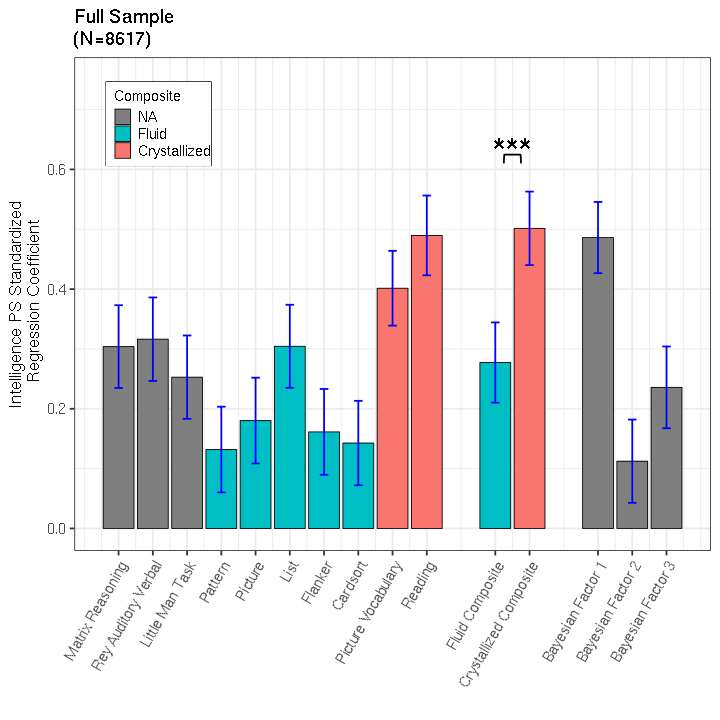

In [346]:
p1 = across_toolbox_plot(model_table[model_table$IV=='IQ_PS', ], '_full_samp', asterix_height=0.63, number_of_aterix=3, asterix_size=8,
                         'Full Sample', legend=TRUE)
p1

In [347]:
p2 = across_toolbox_plot(model_table[model_table$IV=='IQ_PS', ], '_EUR', asterix_height=0.35, number_of_aterix=3, asterix_size=6,
                         'Europeans Only', legend=FALSE)
p3 = across_toolbox_plot(model_table[model_table$IV=='IQ_PS', ], '_nonEUR', asterix_height=0.63, number_of_aterix=1, asterix_size=6, 
                         'Non-Europeans Only', legend=FALSE)

TableGrob (2 x 2) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-2) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (2-2,2-2) arrange gtable[layout]

Saving 6.67 x 6.67 in image


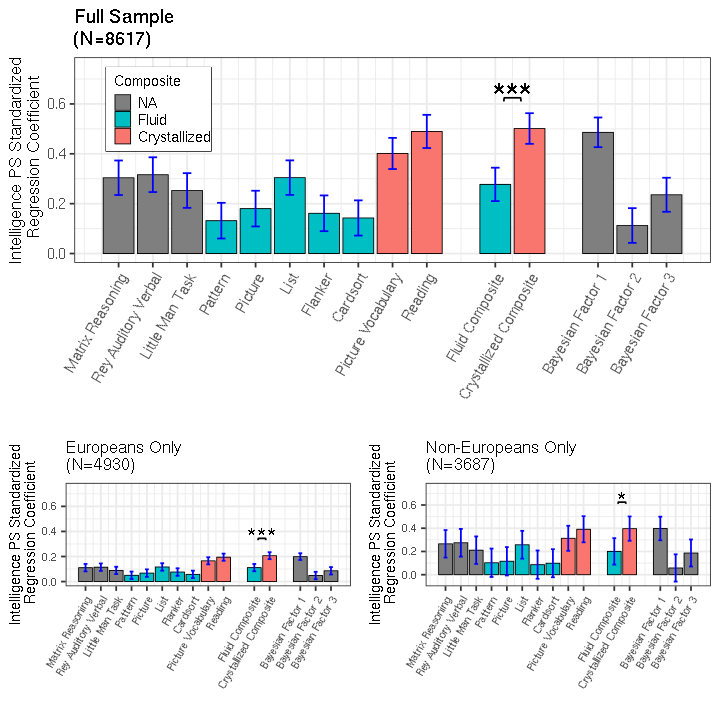

In [348]:
options(repr.plot.width=6, repr.plot.height=6)
tot_p = grid.arrange(
    p1,
    p2,
    p3,
    heights=c(1.8,1.2),
    layout_matrix = rbind(c(1, 1),
                        c(2, 3))
)
tot_p
ggsave('./results/figures/ancestry_strata_results_scale_each_subsample_RAVLT.pdf', tot_p)

In [24]:
fluid_cyrst_ind = (model_table$IV == 'IQ_PS'| model_table$IV == 'EducAttain_PS') & (model_table$DV %in% c('nihtbx_fluidcomp_uncorrected', 'nihtbx_cryst_uncorrected'))

In [117]:
cols_of_interest = colnames(model_table)=='DV' | colnames(model_table)=='IV' | endsWith(colnames(model_table), '_full_samp')
model_table[fluid_cyrst_ind, cols_of_interest]

,DV,IV,coeff_full_samp,coeff_SE_full_samp,upper_full_samp,lower_full_samp,t_full_samp,r2_tstat_full_samp,pval_full_samp,r2_full_full_samp,n_full_full_samp,full_converge_flag_full_samp
11,nihtbx_fluidcomp_uncorrected,IQ_PS,0.27724429,0.03418791,0.34425260,0.21023598,8.109424,0.007592307,5.785884e-16,0.1983351,8617,1
27,nihtbx_fluidcomp_uncorrected,EducAttain_PS,0.05005712,0.01613005,0.08167203,0.01844221,3.103345,0.001119122,1.919676e-03,0.1930587,8617,1
12,nihtbx_cryst_uncorrected,IQ_PS,0.50146728,0.03134430,0.56290211,0.44003245,15.998676,0.028915369,8.579617e-57,0.3233358,8617,1
28,nihtbx_cryst_uncorrected,EducAttain_PS,0.15455915,0.01485806,0.18368095,0.12543735,10.402376,0.012431851,3.410946e-25,0.3114650,8617,1


In [118]:
cols_of_interest = colnames(model_table)=='DV' | colnames(model_table)=='IV' | endsWith(colnames(model_table), '_EUR')
model_table[fluid_cyrst_ind, cols_of_interest]

,DV,IV,coeff_EUR,coeff_SE_EUR,upper_EUR,lower_EUR,t_EUR,r2_tstat_EUR,pval_EUR,r2_full_EUR,n_full_EUR,full_converge_flag_EUR
11,nihtbx_fluidcomp_uncorrected,IQ_PS,0.11159193,0.01480615,0.14061199,0.08257186,7.536861,0.011439089,5.699306e-14,0.1280362,4930,1
27,nihtbx_fluidcomp_uncorrected,EducAttain_PS,0.05058349,0.01438335,0.07877485,0.02239213,3.516809,0.002513111,4.407187e-04,0.1198679,4930,1
12,nihtbx_cryst_uncorrected,IQ_PS,0.20647089,0.01415706,0.23421872,0.17872306,14.584307,0.041529558,3.390036e-47,0.1971931,4930,1
28,nihtbx_cryst_uncorrected,EducAttain_PS,0.16609737,0.01377623,0.19309877,0.13909596,12.056812,0.028760617,5.205360e-33,0.1867520,4930,1


In [119]:
cols_of_interest = colnames(model_table)=='DV' | colnames(model_table)=='IV' | endsWith(colnames(model_table), '_nonEUR')
model_table[fluid_cyrst_ind, cols_of_interest]

,DV,IV,coeff_nonEUR,coeff_SE_nonEUR,upper_nonEUR,lower_nonEUR,t_nonEUR,r2_tstat_nonEUR,pval_nonEUR,r2_full_nonEUR,n_full_nonEUR,full_converge_flag_nonEUR
11,nihtbx_fluidcomp_uncorrected,IQ_PS,0.20059511,0.05804632,0.31436590,0.08682432,3.455776,0.0032470304,5.549409e-04,0.2081586,3687,1
27,nihtbx_fluidcomp_uncorrected,EducAttain_PS,0.03474641,0.02538063,0.08449243,-0.01499962,1.369013,0.0005109763,1.710791e-01,0.2060789,3687,1
12,nihtbx_cryst_uncorrected,IQ_PS,0.39677499,0.05332057,0.50128332,0.29226667,7.441311,0.0148797533,1.235348e-13,0.3309244,3687,1
28,nihtbx_cryst_uncorrected,EducAttain_PS,0.09015449,0.02340833,0.13603481,0.04427416,3.851385,0.0040298389,1.194583e-04,0.3233615,3687,1


# Find Behvariors that were Significnatly Predicted by IPS

In [91]:
ind = model_table[model_table$IV=='IQ_PS', 'pval_nonEUR']<(0.05/length(measures[1:10]))
model_table[model_table$IV=='IQ_PS', ][ind, c('DV', 't_nonEUR', 'pval_nonEUR')]

,DV,t_nonEUR,pval_nonEUR
2,pea_wiscv_trs,4.393452,1.147209e-05
1,pea_ravlt_tc,4.507615,6.760885e-06
3,lmt_scr_perc_correct,3.495553,4.786881e-04
6,nihtbx_list_uncorrected,4.218942,2.513908e-05
4,nihtbx_picvocab_uncorrected,5.686088,1.401345e-08
10,nihtbx_reading_uncorrected,6.813895,1.105862e-11
11,nihtbx_fluidcomp_uncorrected,3.455776,5.549409e-04
12,nihtbx_cryst_uncorrected,7.441311,1.235348e-13
13,nihtbx_totalcomp_uncorrected,6.008051,2.060917e-09
14,neurocog_pc1.bl,7.677021,2.074708e-14


### Plot out EAPS Alongside IQPS for Supplementary Figure 1

In [353]:
ea_iq_ps_plot = function(model_table, suffix, title, legend){
    model_table$pos = model_table$pos + rep(seq(0, (dim(model_table)[1]/2)-1), each=2)

    model_table$Composite = str_replace(str_replace(paste0(model_table$Composite, model_table$IV), 'IQ_', ' I'), 'EducAttain_', ' EA') 

    p = across_toolbox_plot(model_table, suffix, asterix_height=NULL, number_of_aterix=3, asterix_size=8,
                             title=title, legend=legend, y_max=.75, ylab='Polygenic Score \n Standardized Regression Coefficient')
    # Create Single Labels for groups
    pos_ind = rep(c(FALSE, TRUE), times=dim(model_table)[1]/2)
    p = p +  scale_x_continuous(breaks=model_table$pos[pos_ind]-0.5, labels=unique(model_table$dependant_var_nice_name)) + 
    scale_fill_manual(values=c("#56B4E9", "#1535f9", "#ee7288", "#d11915", "#afafaf", "#7c7c7c"))
    return(p)
}

In [354]:
g_legend<-function(a.gplot){
    tmp <- ggplot_gtable(ggplot_build(a.gplot))
    leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
    legend <- tmp$grobs[[leg]]
    legend
}

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


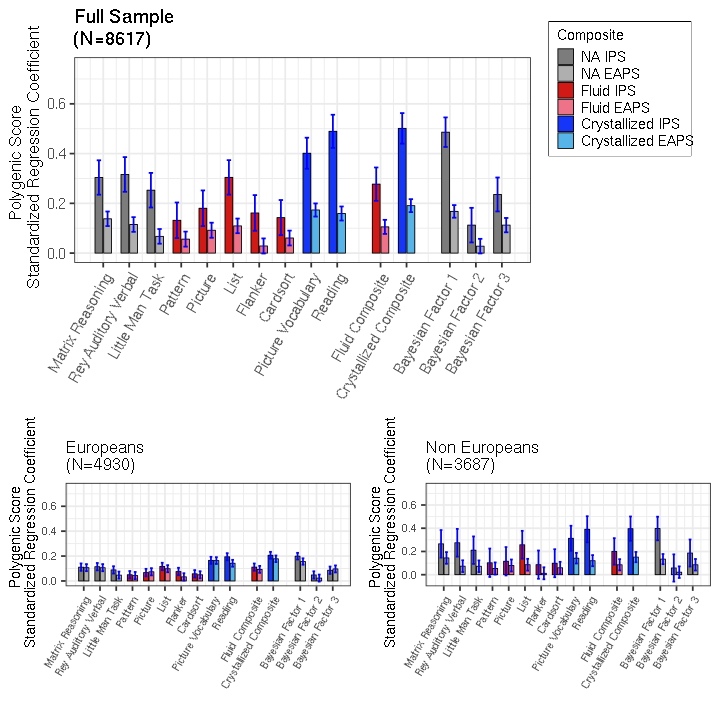

In [355]:
p1 = ea_iq_ps_plot(model_table, '_full_samp', 'Full Sample', TRUE) 
legend = g_legend(p1)
p1 = p1 + theme(legend.position = "none") 
p2 = ea_iq_ps_plot(model_table, '_EUR', 'Europeans', FALSE) 
p3 = ea_iq_ps_plot(model_table, '_nonEUR', 'Non Europeans', FALSE)
options(repr.plot.width=6, repr.plot.height=6)
tot_p = grid.arrange(
    p1,
    legend,
    p2,
    p3,
    heights=c(1.8,1.2),
    layout_matrix = rbind(c(1, 1, 1, 2),
                        c(3, 3, 4, 4))
)

# ggsave('./results/figures/ancestry_strata_results_IPS_and_EAPS.pdf', tot_p)

# Save Out Model Coeffs

In [307]:
save_PS_reg_results = function(suffix, model_table, model_table_combined){
    # Save out Individual Regressions
    cols = c('dependant_var_nice_name', paste0(c('coeff', 'r2_tstat', 't', 'pval'), '_', suffix))
    out_table = cbind(filter(model_table, IV=='IQ_PS')[, cols], filter(model_table, IV=='EducAttain_PS')[, cols[-1]])
    colnames(out_table)[1] = 'Behavior'
    colnames(out_table) = str_replace(colnames(out_table), paste0('_', suffix), '')
    colnames(out_table) = str_replace(colnames(out_table), '_tstat', '')
    write.table(format(out_table, digits=2), paste0('results/', suffix, '_univar.csv'), row.names=F, quote=F, sep=',')

    # combined _regression
    combined_cols = c('dependant_var_nice_name', paste0(c('IPS_coeff', 'IPS_t', 'EAPS_coeff','EAPS_t', 'r2_delta', 'lrt_chisq', 'lrt_pval'), '_', suffix))
    out_table = model_table_combined[, combined_cols]
    colnames(out_table)[1] = 'Behavior'
    colnames(out_table) = str_replace(colnames(out_table), paste0('_', suffix), '')
    colnames(out_table) = str_replace(colnames(out_table), '_tstat', '')
    colnames(out_table) = str_replace(colnames(out_table), '_delta', '')
    colnames(out_table) = str_replace(colnames(out_table), 'lrt_', '')
    write.table(format(out_table, digits=2), paste0('results/', suffix, '_multivar.csv'), row.names=F, quote=F, sep=',')
}

In [308]:
save_PS_reg_results('full_samp', model_table, model_table_combined)
save_PS_reg_results('EUR', model_table, model_table_combined)
save_PS_reg_results('nonEUR', model_table, model_table_combined)

## Save Full Table of Regression Results from Crystallized and Fluid

In [197]:
save_regression_results = function(df, model_table, suffix){
    res = run_models(model_table=model_table, df, QN_IVs=FALSE, QN_gauss_DVs=FALSE, suffix=suffix, return_models=TRUE)
    full_models = res$full
    for (i in seq(1, dim(model_table)[1])){
        regression_res = summary(full_models[,i]$gam)
        behavior = str_replace(str_replace(model_table[i, 'DV'], 'nihtbx_', ''), '_uncorrected', '')
        # calculate r2
        fixed_effects = regression_res$p.table
        ts = as.numeric(regression_res$p.t)
        DF = as.numeric(regression_res$residual.df)
        r2 = (ts^2/(ts^2 + DF))
        out_table = cbind(round(cbind(fixed_effects, r2)[, c(1, 2, 3, 5)], 4), format(fixed_effects[, 4], scientific = T, digits=4))
        colnames(out_table)[5] = 'Pval' 
        write.table(out_table, paste0(suffix, '_', behavior, '.csv'), quote=FALSE, sep=',', col.names = NA, row.names = TRUE)
    }
}
# mod_tab = filter(filter(model_table, IV=='IQ_PS'), DV=='nihtbx_fluidcomp_uncorrected' | DV=='nihtbx_cryst_uncorrected')


# # Full sample 
# sub_df = df
# sub_df[, c(measures, pc_cols, poly_score, 'Age')] = scale(sub_df[, c(measures, pc_cols, poly_score, 'Age')])
# save_regression_results(sub_df, mod_tab, 'results/full_samp')

# # Europeans
# sub_df = df[df$EUR>0.9, ]
# sub_df[, c(measures, pc_cols, poly_score, 'Age')] = scale(sub_df[, c(measures, pc_cols, poly_score, 'Age')])
# save_regression_results(sub_df, mod_tab, 'results/EUR')

# # Non Europeans
# sub_df = df[df$EUR<0.9, ]
# sub_df[, c(measures, pc_cols, poly_score, 'Age')] = scale(sub_df[, c(measures, pc_cols, poly_score, 'Age')])
# save_regression_results(sub_df, mod_tab, 'results/nonEUR')

[1] "Gamma variables:"
character(0)
[1] "Binomial variables:"
character(0)
[1] "Parallel processing not currently available with gamm4. Number of cores set to 1."
[1] "Fitting nihtbx_fluidcomp_uncorrected ~ IQ_PS + Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting nihtbx_cryst_uncorrected ~ IQ_PS + Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Gamma variables:"
character(0)
[1] "Binomial variables:"
character(0)
[1] "Parallel processing not currently available with gamm4. Number of cores set to 1."
[1] "Fitting nihtbx_fluidcomp_uncorrected ~ IQ_PS + Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
[1] "Fitting nihtbx_cryst_uncorrected ~ IQ_PS + Sex + ParentMarried + Age + Parent.Educ + Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC

# Test Difference Between Coefficients in Two Models

We want to show a significant difference in the standardized regression coefficients of Fluid and Crysallized scales. 

Compute standard error in difference:


$$ \sigma = \sqrt{\sigma_a^2 + \sigma_b^2} $$

Then compute z-score for difference using combined standard error.

$$ Z = \frac{\beta_a - \beta_b}{\sigma}$$

Here $a$ and $b$ index fluid and crysalized composite scales.

In [56]:
z_test = function(measure_a, measure_b, sample_a, sample_b, model_table_a, model_table_b=NULL){
    row.names(model_table_a) = model_table_a$DV
    if (is.null(model_table_b)){
        model_table_b = model_table_a
    }
    
    se_a = model_table_a[measure_a, paste0('coeff_SE_', sample_a)]
    se_b = model_table_b[measure_b, paste0('coeff_SE_', sample_b)]

    beta_a = model_table_a[measure_a, paste0('coeff_', sample_a)]
    beta_b = model_table_b[measure_b, paste0('coeff_', sample_b)]
    z_score = (beta_a-beta_b)/sqrt(se_a^2 + se_b^2)
    pval = 2*pnorm(-abs(z_score))
    
    measure_a = str_replace(str_replace(measure_a, 'nihtbx_', ''), '_uncorrected', '')
    measure_b = str_replace(str_replace(measure_b, 'nihtbx_', ''), '_uncorrected', '')
    cat(sprintf('Difference in regression coefficients for %s and %s p=%.3e (z=%.3f)\n', measure_a, measure_b, pval, z_score))
}

In [59]:
cat('Full Sample:\t')
z_test('nihtbx_cryst_uncorrected', 'nihtbx_fluidcomp_uncorrected', 'full_samp', 'full_samp', model_table[model_table$IV=='IQ_PS', ])
cat('European Ancestry:\t')
z_test('nihtbx_cryst_uncorrected', 'nihtbx_fluidcomp_uncorrected', 'EUR', 'EUR', model_table[model_table$IV=='IQ_PS', ])
cat('Admixed Ancestry:\t')
z_test('nihtbx_cryst_uncorrected', 'nihtbx_fluidcomp_uncorrected', 'nonEUR', 'nonEUR', model_table[model_table$IV=='IQ_PS', ])

Full Sample:	Difference in regression coefficients for cryst and fluidcomp p=1.336e-06 (z=4.834)
European Ancestry:	Difference in regression coefficients for cryst and fluidcomp p=3.629e-06 (z=4.632)
Admixed Ancestry:	Difference in regression coefficients for cryst and fluidcomp p=1.281e-02 (z=2.489)


# Mediation Analysis

In [199]:
df[, 'log_reading'] = as.numeric(scale(log(df$sports_activity_read_hours_p+0.1)))

In [205]:
set.seed(1)
sub_df = select_singletons(na.omit(df[df$EUR>0.9, c(nihtbx_names[8:9], 'IQ_PS', covariates, 'rel_family_id', 'abcd_site', 'log_reading')]))
sub_df[, c(nihtbx_names[8:9], pc_cols, 'IQ_PS', 'Age', 'log_reading')] = scale(sub_df[, c(nihtbx_names[8:9], pc_cols, 'IQ_PS', 'Age', 'log_reading')])
print(paste0('Additional ', sum(is.na(df[df$EUR>0.9, 'log_reading'])), ' removed, ', sum(!is.na(df[df$EUR>0.9, 'log_reading'])), ' remaining, ', dim(sub_df)[1], ' singletons'))

[1] "Additional 1214 removed, 3716 remaining, 3275 singletons"


In [206]:
sub_df$Parent.Educ <- relevel(sub_df$Parent.Educ, ref="Some College")
sub_df$Household.Income <- relevel(sub_df$Household.Income, ref="[>=50K & <100K]")


Family: gaussian 
Link function: identity 

Formula:
log_reading ~ IQ_PS + Sex + ParentMarried + Age + Parent.Educ + 
    Household.Income + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + 
    PC8 + PC9 + PC10

Parametric coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     -0.200221   0.072476  -2.763 0.005766 ** 
IQ_PS                            0.127460   0.019009   6.705 2.36e-11 ***
SexM                            -0.053601   0.034500  -1.554 0.120363    
ParentMarriedyes                 0.108150   0.053124   2.036 0.041853 *  
Age                              0.037957   0.017541   2.164 0.030545 *  
Parent.Educ< HS Diploma          0.153619   0.352464   0.436 0.662979    
Parent.EducHS Diploma/GED       -0.140211   0.131400  -1.067 0.286026    
Parent.EducBachelor              0.092368   0.057212   1.614 0.106519    
Parent.EducPost Graduate Degree  0.192322   0.056673   3.394 0.000698 ***
Household.Income[<50K]      

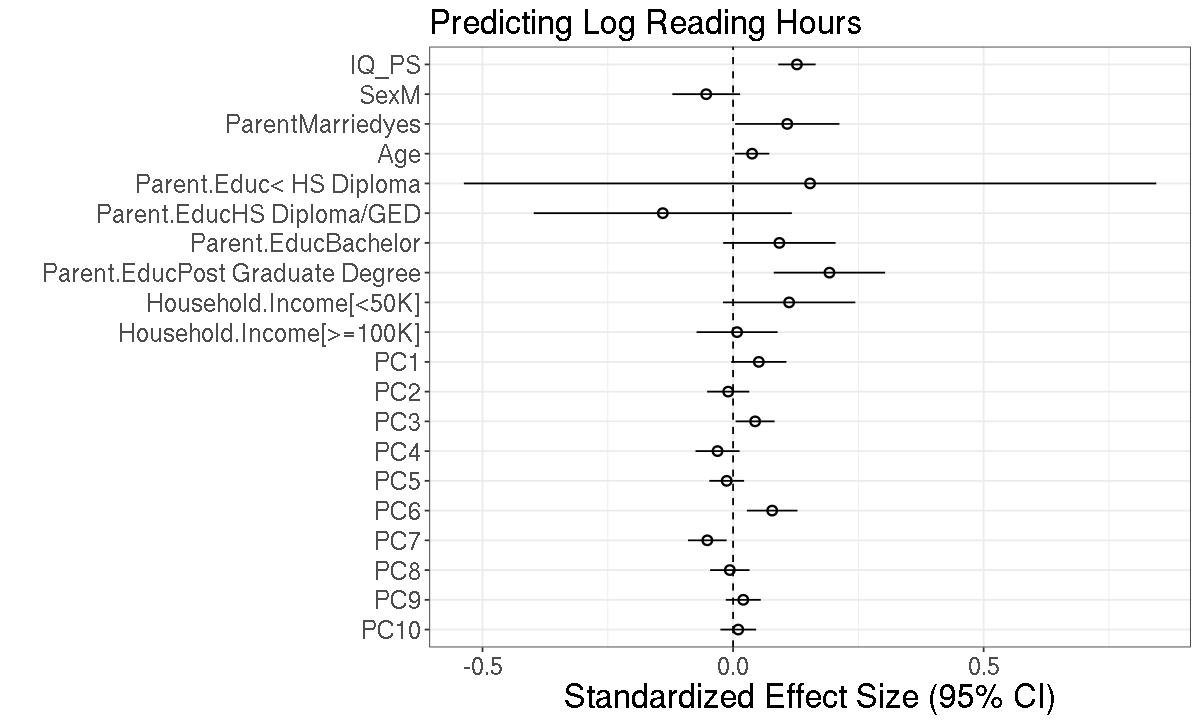

In [207]:
form = paste0('log_reading ~  IQ_PS + ', covariate_str)
model = gamm4(formula=formula(form), random=formula('~(1|abcd_site)'), data=sub_df)

summary = summary(model$gam)
summary
ind = 2:length(model$gam$coefficients)
label <- names(model$gam$coefficients[ind])
coeff  <- model$gam$coefficients[ind]
lower <- model$gam$coefficients[ind]-1.96*summary$se[ind]
upper <- model$gam$coefficients[ind]+1.96*summary$se[ind]

df_coeff <- data.frame(label, coeff, lower, upper)

# reverses the factor level ordering for labels after coord_flip()
df_coeff$label <- factor(df_coeff$label, levels=rev(df_coeff$label))
options(repr.plot.width=10, repr.plot.height=6)



fp <- ggplot(data=df_coeff, aes(x=label, y=coeff, ymin=lower, ymax=upper)) +
        geom_pointrange(position = position_dodge(0.5), shape=1) + 
        geom_hline(yintercept=0, lty=2) +  # add a dotted line at x=1 after flip
        coord_flip() +  # flip coordinates (puts labels on y axis)
        xlab("") + ylab("Standardized Effect Size (95% CI)") + ggtitle("Predicting Log Reading Hours") + 
        theme_bw() + theme(text = element_text(size=18)) # use a white background
print(fp)

In [208]:
# Writing own function 
mediation_atten = function(data, indicies, measures){
    sub_df = data[indicies, ]
    coeff_atten = c()
    for (i in 1:length(measures)){
        reduced = lm(formula(paste(measures[i], ' ~ IQ_PS + ', covariate_str)), data=sub_df)
        full = lm(formula(paste(measures[i], ' ~ IQ_PS + log_reading + ', covariate_str)), data=sub_df)
        reduced_coeff = summary(reduced)$coefficients['IQ_PS', 'Estimate']
        full_coeff = summary(full)$coefficients['IQ_PS', 'Estimate']
        coeff_atten_tmp = c(full_coeff/(reduced_coeff))
        coeff_atten = rbind(coeff_atten, coeff_atten_tmp)
    }
    return(coeff_atten)
}

In [215]:
set.seed(2)
tic()
boot_results = boot(data=sub_df,
               statistic=mediation_atten,
               measures=nihtbx_names[8:9],
               R=10000,
               parallel = "multicore",
               ncpus=30)
toc()

elapsed time is 188.315000 seconds 


In [237]:
res_ttest = t.test(boot_results$t[, 1], boot_results$t[, 2])
res_ttest


	Welch Two Sample t-test

data:  boot_results$t[, 1] and boot_results$t[, 2]
t = 218.19, df = 19946, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.08029950 0.08175533
sample estimates:
mean of x mean of y 
0.9164572 0.8354298 


In [250]:
pt(res_ttest$statistic, res_ttest$parameter, lower.tail=F, log.p = T) + log(2)

t 
-12170.74

In [315]:
plot_hists = function(results){
    options(repr.plot.width=4, repr.plot.height=4)
    n_boot = dim(results$t)[1]
    coefs_diffs = -melt(1- results$t)
    # coefs_diffs = melt(red_coefs)
    coefs_diffs$Composite = c(rep('Fluid', n_boot), rep('Crystallized', n_boot))
    
    options(repr.plot.width=5, repr.plot.height=3)
    p = ggplot(coefs_diffs, aes(x=value, color=Composite)) +
      geom_histogram(position="identity", alpha=0.25, bins=100, size=.2) + xlab('Fractional Attenuation of Coefficent') +
    xlim(c(-0.25, 0))
    return(p)
}


Warning message:
"Removed 54 rows containing non-finite values (stat_bin)."Warning message:
"Removed 4 rows containing missing values (geom_bar)."

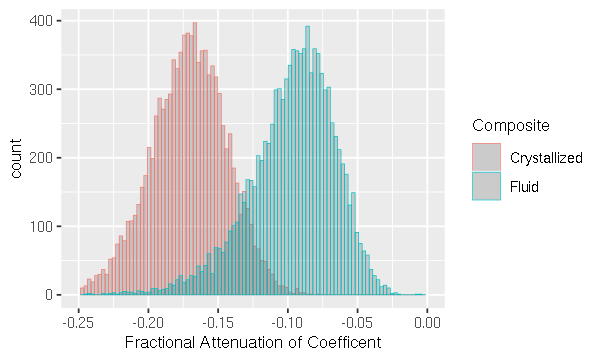

In [318]:
p = plot_hists(boot_results)
p
# ggsave('./results/figures/mediation_EUR_singletons.pdf', p, width=4, height=2)

# Mediation Simulated Noise - Supplmentary

In [469]:
noisy_mediation = function(sd, boot_results, measure, sub_df, nboot){
    noisy_measure = paste0(measure, '_noise')
    sub_df[, noisy_measure] = sub_df[, measure] + rnorm(dim(sub_df)[1], sd=sd)
    res_1 = boot(data=sub_df, statistic=mediation_atten, measures=c(noisy_measure), R=nboot, parallel = "multicore", ncpus=30)
    ttest = t.test(boot_results$t[, 1], res_1$t)
    return(list(attens=res_1$t, 
                ttest=ttest,
           pval=ttest$p.value,
                logp = pt(ttest$statistic, ttest$parameter, lower.tail=F, log.p = T) + log(2),
               cor=cor(sub_df[, c(measure, noisy_measure)])[1, 2]))
}


In [468]:
tic()
res_1 = noisy_mediation(sd=sds[s], 
                       boot_results=boot_results, 
                       measure='nihtbx_cryst_uncorrected',
                       sub_df=sub_df[, c('nihtbx_cryst_uncorrected', poly_score, covariates, 'log_reading', 'abcd_site', 'rel_family_id')], 
                       10000)
toc()

elapsed time is 107.903000 seconds 


In [ ]:
sds = c(0, 0.5, 0.75, 1, 1.25, 1.5, 2, 2.5, 3, 4)
sds = rep(sds, 100)
res = list()
for (s in seq_along(sds)){
    res[[s]]  = noisy_mediation(sd=sds[s], 
                       boot_results=boot_results, 
                       measure='nihtbx_cryst_uncorrected',
                       sub_df=sub_df[, c('nihtbx_cryst_uncorrected', poly_score, covariates, 'log_reading', 'abcd_site', 'rel_family_id')], 
                       10000)
}

In [489]:

# for (i in seq_along(res)){
#     res[[i]]$logp = welch_logp(res[[i]]$atten, results$t[, 3])
# }

logp = as.numeric(res %>% map(c('logp')))
corr = as.numeric(res %>% map(c('cor')))

options(repr.plot.width=4, repr.plot.height=4)
p = ggplot(data.frame(corr=as.numeric(corr), logp=-logp), aes(1-corr^2, logp)) + 
theme( plot.margin = unit(c(5.5,12,5.5,5.5), "pt")) + 
geom_point(size=0.1) +
geom_hline(yintercept=-log(5*10^-2), linetype="dashed", color = "red") + 
geom_smooth() + xlab(TeX('Proportion of Noise $Cryst_{noise}$: $(1- r^2)$')) 
ggsave('./results/figures/Suplementary_figure_3.pdf', p, width=4, height=4)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


In [490]:
write.table(data.frame(corr=as.numeric(corr), logp=-logp), 'results/mediation_noise_results_boot_10000.csv', col.names=FALSE, quote=FALSE)

# Simulate Different Values of Noise - Crystallized Fluid Difference

In [ ]:
noisy_assocaition = function(sd, fluid_res, sub_df){
    sub_df[, 'nihtbx_cryst_uncorrected_noise'] =  scale(sub_df[, 'nihtbx_cryst_uncorrected'] + rnorm(dim(sub_df)[1], sd=sd))
    form = paste0('nihtbx_cryst_uncorrected_noise', ' ~  IQ_PS +', covariate_str)
    cryst_model = gamm4(formula=formula(form), random=formula(ran), data=sub_df)
    cryst_summry = summary(cryst_model$gam)
    cryst_res = list(ps=cryst_summry$p.table['IQ_PS', 'Estimate'],
     serr=cryst_summry$p.table['IQ_PS', 'Std. Error'])
    
    
    combined_err = sqrt(cryst_res$serr^2 + fluid_res$serr^2)
    difference = as.numeric(cryst_res$ps - fluid_res$ps)
    cor_val = cor(sub_df[, c('nihtbx_cryst_uncorrected_noise', 'nihtbx_cryst_uncorrected')])[1,2]
    pval = pnorm(difference, sd=combined_err, lower.tail=FALSE)
    return(list(diff=difference, err=combined_err, p=pval, cor=cor_val))
}

In [ ]:
sub_df = df
sub_df[, c(measures, pc_cols, poly_score, 'Age')] = scale(sub_df[, c(measures, pc_cols, poly_score, 'Age')])

In [ ]:
form = paste0('nihtbx_fluidcomp_uncorrected', ' ~  IQ_PS +', covariate_str)
fluid_model = gamm4(formula=formula(form), random=formula(ran), data=sub_df)
sumry = summary(fluid_model$gam)
fluid_res = list(ps=sumry$p.table['IQ_PS', 'Estimate'],
     serr=sumry$p.table['IQ_PS', 'Std. Error'])

In [ ]:
sd = seq(0, 2, 0.25)
sd = rep(sd, 1000)
res_scale = mcmapply(sd, FUN=noisy_assocaition, MoreArgs=list(fluid_res=fluid_res, sub_df=sub_df), mc.cores=10)

In [60]:
write.table(res_scale, 'results/cryst_noise_vs_fluid_preicitive_diff.csv', col.names=FALSE, quote=FALSE)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


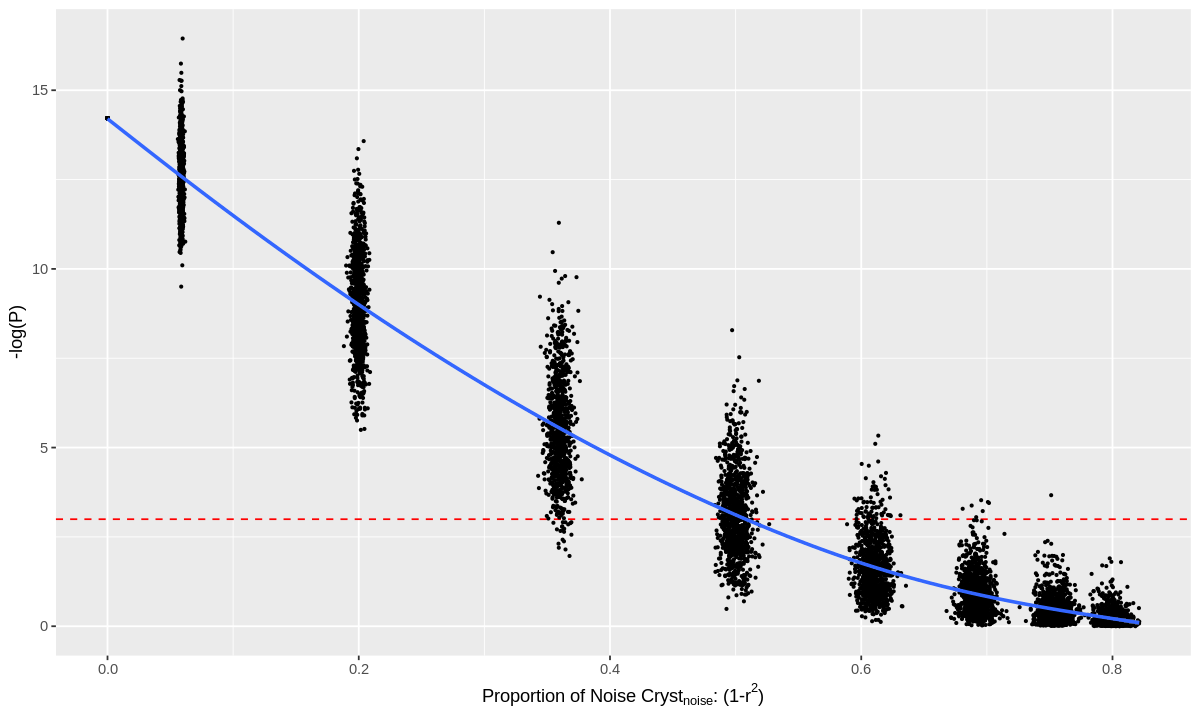

In [87]:
p = ggplot(data.frame(sapply(data.frame(t(res_scale)), as.numeric)), aes(1-cor^2, -log(p))) + 
geom_hline(yintercept=-log(5*10^-2), linetype="dashed", color = "red") + 
geom_point(size=0.5) + 
 xlab(TeX("Proportion of Noise $Cryst_{noise}$: $(1- r^2)$")) + 
ylab('-log(P)') + 
geom_smooth()
p
ggsave('./results/figures/Suplementary_figure_2.pdf', p, width=4, height=4)

In [115]:
matched_noise_ind = (data.frame(res_scale)['cor', ]>0.75 & data.frame(res_scale)['cor', ]<0.85)
power = sum(data.frame(res_scale)['p', matched_noise_ind]<0.05)/sum(matched_noise_ind)
print(paste0('At matched noise level for Cryst_noise with Fluid we still have ', power, ' power to detect difference in standardized IPS coefficient size'))

[1] "At matched noise level for Cryst_noise with Fluid we still have 0.98 power to detect difference in standardized IPS coefficient size"


# Total Cortical Area and Mean Thickness Associations

In [375]:
cortical_measures = c('smri_area_cort.desikan_total', 'smri_thick_cort.desikan_mean')
model_table_cort = data.frame(dependant_var=rep(cortical_measures, length(poly_score)), 
           prs=rep(poly_score, each=length(cortical_measures)))
model_table_cort$full = paste0(model_table_cort$dependant_var, ' ~ ', model_table_cort$prs, ' + ', covariate_str, ' + mri_info_device.serial.number')
model_table_cort$reduced = paste0(model_table_cort$dependant_var, ' ~ ', covariate_str, ' + mri_info_device.serial.number')

In [ ]:
model_table_cort = fit_gamm_models(dat=df, model_table=model_table_cort, suffix='_full_samp')

In [382]:
model_table_cort = fit_gamm_models(dat=df[EUR_ind,], model_table=model_table_cort, suffix='_EUR')

Warning message:
"Some predictor variables are on very different scales: consider rescaling"Warning message:
"Some predictor variables are on very different scales: consider rescaling"Warning message:
"Some predictor variables are on very different scales: consider rescaling"Warning message:
"Some predictor variables are on very different scales: consider rescaling"refitting model(s) with ML (instead of REML)
Warning message in `[<-.data.frame`(`*tmp*`, ind, paste0("anova", suffix), value = structure(list(:
"replacement element 1 has 2 rows to replace 1 rows"Warning message in `[<-.data.frame`(`*tmp*`, ind, paste0("anova", suffix), value = structure(list(:
"replacement element 2 has 2 rows to replace 1 rows"Warning message in `[<-.data.frame`(`*tmp*`, ind, paste0("anova", suffix), value = structure(list(:
"replacement element 3 has 2 rows to replace 1 rows"Warning message in `[<-.data.frame`(`*tmp*`, ind, paste0("anova", suffix), value = structure(list(:
"replacement element 4 has 2 ro

In [387]:
model_table_cort = fit_gamm_models(dat=df[!EUR_ind,], model_table=model_table_cort, suffix='_non_EUR')

refitting model(s) with ML (instead of REML)
Warning message in `[<-.data.frame`(`*tmp*`, ind, paste0("anova", suffix), value = structure(list(:
"replacement element 1 has 2 rows to replace 1 rows"Warning message in `[<-.data.frame`(`*tmp*`, ind, paste0("anova", suffix), value = structure(list(:
"replacement element 2 has 2 rows to replace 1 rows"Warning message in `[<-.data.frame`(`*tmp*`, ind, paste0("anova", suffix), value = structure(list(:
"replacement element 3 has 2 rows to replace 1 rows"Warning message in `[<-.data.frame`(`*tmp*`, ind, paste0("anova", suffix), value = structure(list(:
"replacement element 4 has 2 rows to replace 1 rows"Warning message in `[<-.data.frame`(`*tmp*`, ind, paste0("anova", suffix), value = structure(list(:
"replacement element 5 has 2 rows to replace 1 rows"Warning message in `[<-.data.frame`(`*tmp*`, ind, paste0("anova", suffix), value = structure(list(:
"replacement element 6 has 2 rows to replace 1 rows"Warning message in `[<-.data.frame`(`*tmp*`

In [385]:
model_table_cort[,endsWith(colnames(model_table_cort), '_full_samp')]

PS_coeff_full_samp,PS_coeff_SE_full_samp,upper_full_samp,lower_full_samp,t_full_samp,pval_full_samp,r2_delta_full_samp,lrt_chisq_full_samp,lrt_pval_full_samp,anova_full_samp,n_full_full_samp,n_reduced_full_samp
3.065738e+03,549.3868111,4.142536e+03,1.988940e+03,5.580291,2.472095e-08,0.0035132681,31.266999,2.248698e-08,51,8884,8884
7.157104e-03,0.0035713,1.415685e-02,1.573565e-04,2.004061,4.509395e-02,0.0004588218,4.029387,4.471418e-02,51,8884,8884


In [384]:
model_table_cort[,endsWith(colnames(model_table_cort), 'EUR')]

PS_coeff_EUR,PS_coeff_SE_EUR,upper_EUR,lower_EUR,t_EUR,pval_EUR,r2_delta_EUR,lrt_chisq_EUR,lrt_pval_EUR,anova_EUR,n_full_EUR,n_reduced_EUR
3739.6292559,6.903137e+02,5.092644e+03,2.386614e+03,5.417290,6.331639e-08,0.005781617,29.565003,5.407248e-08,51,5097,5097
0.0103389,4.473859e-03,1.910767e-02,1.570140e-03,2.310959,2.087522e-02,0.001058094,5.396316,2.017930e-02,51,5097,5097


In [388]:
model_table_cort[,endsWith(colnames(model_table_cort), 'non_EUR')]

PS_coeff_non_EUR,PS_coeff_SE_non_EUR,upper_non_EUR,lower_non_EUR,t_non_EUR,pval_non_EUR,r2_delta_non_EUR,lrt_chisq_non_EUR,lrt_pval_non_EUR,anova_non_EUR,n_full_non_EUR,n_reduced_non_EUR
2.258572e+03,9.385628e+02,4.098155e+03,418.9885872,2.4064151,0.01615818,1.548180e-03,5.8679609,0.0154189,51,3787,3787
-2.507849e-03,6.125024e-03,9.497199e-03,-0.0145129,-0.4094431,0.68223795,3.524812e-05,0.1754288,0.6753314,51,3787,3787
